## 0. loading packages

In [19]:
import os, sys
import codecs
import gensim
import pickle
import sqlite3
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## 1. loading and quick inspection of data

In [7]:
data_path = '../data'
config_path = '../config'

In [8]:
con = sqlite3.connect(os.path.join(data_path, 'database.sqlite'))
cursor = con.cursor()

In [43]:
table = pd.read_sql_query("SELECT * FROM Reviews;", con)

In [44]:
table.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


- Id
- ProductId - unique identifier for the product
- UserId - unqiue identifier for the user
- ProfileName
- HelpfulnessNumerator - number of users who found the review helpful
- HelpfulnessDenominator - number of users who indicated whether they found the review helpful
- Score - rating between 1 and 5
- Time - timestamp for the review
- Summary - brief summary of the review
- Text - text of the review

In [45]:
table.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


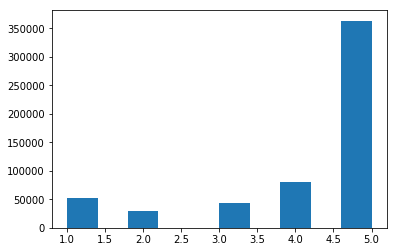

In [46]:
plt.hist(table.Score)
plt.show()

In [47]:
def assign_sentiment(score, label=False):
    if score > 3:
        return "Positive" if not label else 1
    elif score < 3:
        return "Negative" if not label else 3
    else:
        return "Neutral" if not label else 2

In [48]:
table['Sentiment'] = table.Score.apply(assign_sentiment)
table['ClassLabel'] = table.Score.apply(assign_sentiment, label=True)

In [49]:
table.Sentiment.value_counts()

Positive    443777
Negative     82037
Neutral      42640
Name: Sentiment, dtype: int64

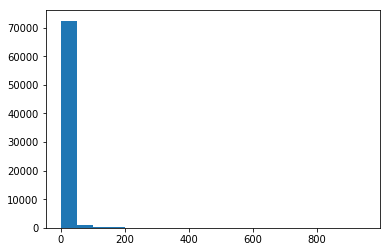

In [50]:
plt.hist([table.ProductId.value_counts()], bins=np.arange(0,1000,50))
plt.show()

In [53]:
data = table[['ProductId', 'Score', 'Summary', 'Text', 'Sentiment', 'ClassLabel']]

In [54]:
data.head()

,ProductId,Score,Summary,Text,Sentiment,ClassLabel
0,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,3
2,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,Negative,3
4,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...,Positive,1
